# Validation_index of DSB_Dataset

* ver 1 ; title과 데이터셋 길이(len_label 부여)로 val_index 구성
* ver 2 : title과 데이터셋 길이(len_label 부여)로 val_index 구성 + random shuffle 추가
* ver 3 : title과 데이터셋 길이(len_label 부여)로 val_index 구성 + loop 변경(len_label -> title)

In [1]:
# Any results you write to the current directory are saved as output.
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import json
from time import time
from tqdm import tqdm_notebook as tqdm
from collections import Counter
from scipy import stats
import lightgbm as lgb
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import GroupKFold, KFold
import gc

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import tqdm
from tqdm import tqdm_notebook
import os

import random
import pickle

#Print control function
print('Set print')
def print_expand():
    pd.set_option('display.max_columns', None)  # or 1000
    pd.set_option('display.max_rows', 100)  # or 1000
    pd.set_option('display.max_colwidth', -1)  # or 199
    
def print_basic():
    pd.set_option('display.max_columns', 30)  # or 1000
    pd.set_option('display.max_rows', 30)  # or 1000
    pd.set_option('display.max_colwidth', 50)  # or 199

Set print


In [2]:
'''%%time
# Read in the data CSV files
#train = pd.read_csv('../input/data-science-bowl-2019/train.csv')
#train_labels = pd.read_csv('../input/data-science-bowl-2019/train_labels.csv')
test = pd.read_csv('../input/data-science-bowl-2019/test.csv')
specs = pd.read_csv('../input/data-science-bowl-2019/specs.csv')
sample_submission = pd.read_csv('../input/data-science-bowl-2019/sample_submission.csv')


#ids = train_labels.installation_id.unique()
#train = train[train['installation_id'].isin(list(ids))].reset_index(drop=True)

#Type change
#train['timestamp'] = pd.to_datetime(train['timestamp'])
test['timestamp'] = pd.to_datetime(test['timestamp'])'''

"%%time\n# Read in the data CSV files\n#train = pd.read_csv('../input/data-science-bowl-2019/train.csv')\n#train_labels = pd.read_csv('../input/data-science-bowl-2019/train_labels.csv')\ntest = pd.read_csv('../input/data-science-bowl-2019/test.csv')\nspecs = pd.read_csv('../input/data-science-bowl-2019/specs.csv')\nsample_submission = pd.read_csv('../input/data-science-bowl-2019/sample_submission.csv')\n\n\n#ids = train_labels.installation_id.unique()\n#train = train[train['installation_id'].isin(list(ids))].reset_index(drop=True)\n\n#Type change\n#train['timestamp'] = pd.to_datetime(train['timestamp'])\ntest['timestamp'] = pd.to_datetime(test['timestamp'])"

## Load train data

In [3]:
train_data = pd.read_csv('../input/new-train/new_train_v15.csv')

In [4]:
train_data2 = pd.read_csv('../input/new-train/new_train_v13.csv')

## Check ; val_idx 의 accuracy_group

In [5]:
import pickle
with open('../input/new-train/val_dict.pkl', 'rb') as f:
    val_dict = pickle.load(f)

class는 잘 섞여이지만, sample의 번호가 첫 fold는 낮고, 나중은 높다. -> installation_id가 겹쳐있다.

[   0    1    2 ... 4016 4021 4058]
[2544 2883 2888 ... 7709 7716 7901]
[ 5794  5797  5799 ... 11515 11516 11562]
[ 9862  9881 10050 ... 15048 15089 16257]
[13360 13378 13381 ... 17687 17688 17689]


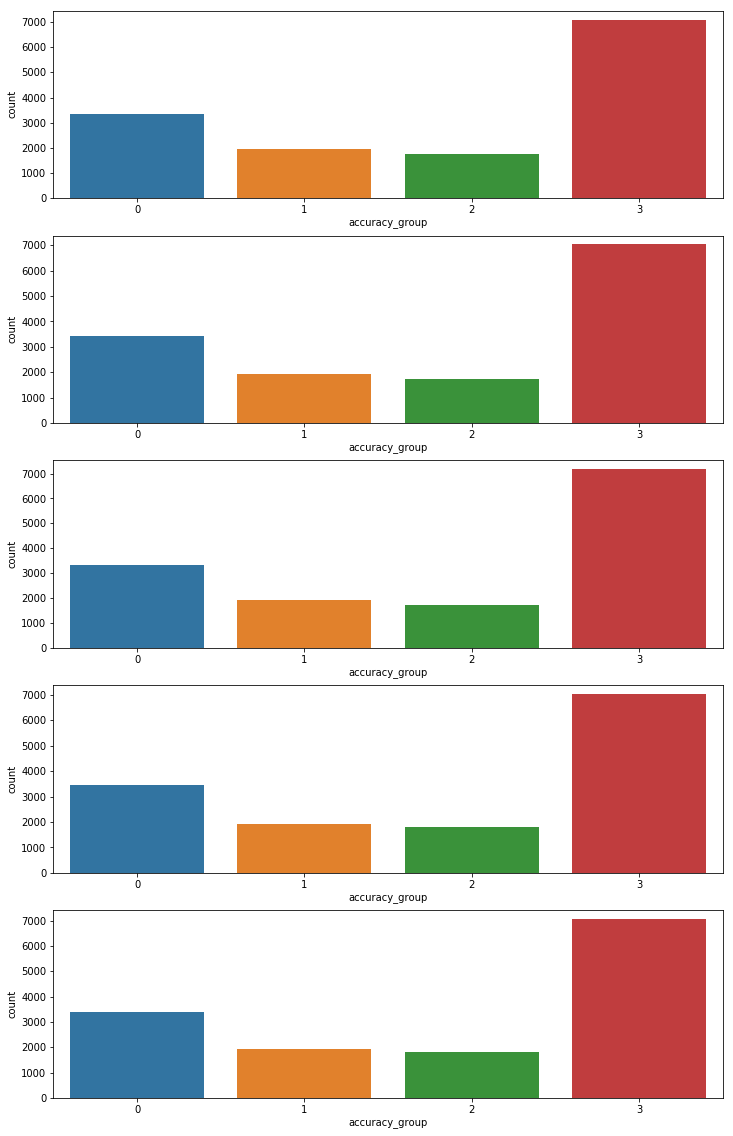

In [6]:
fig, ax = plt.subplots(5,1, figsize=(12,20))
for n_fold in range(5):
    val_idx = val_dict[n_fold]
    print(np.sort(val_idx))
    tr_idx = train_data.index[train_data.index.isin(val_idx) == False]
    sns.countplot(train_data.loc[tr_idx]['accuracy_group'], ax=ax[n_fold])
    #sns.countplot(train_data.loc[tr_idx]['title'], ax=ax[n_fold])

## Len으로 분포 알아보기

In [7]:
np.quantile(train_data2['len'], 0.95), np.quantile(train_data2['len'], 0.5), np.quantile(train_data2['len'], 0.05)

(9750.0, 1309.0, 72.45000000000005)

In [8]:
train_data2['len_label'] = None

In [9]:
train_data2.loc[(train_data2['len'] > np.quantile(train_data2['len'], 0.95)), 'len_label'] = 6
train_data2.loc[(train_data2['len'] < np.quantile(train_data2['len'], 0.05)), 'len_label'] = 0

k = train_data2[(train_data2['len'] >= np.quantile(train_data2['len'], 0.05)) & (train_data2['len'] <= np.quantile(train_data2['len'], 0.95))]['len']
train_data2.loc[k.index, 'len_label'] = pd.qcut(k, 5, labels=[i for i in range(1,6)])

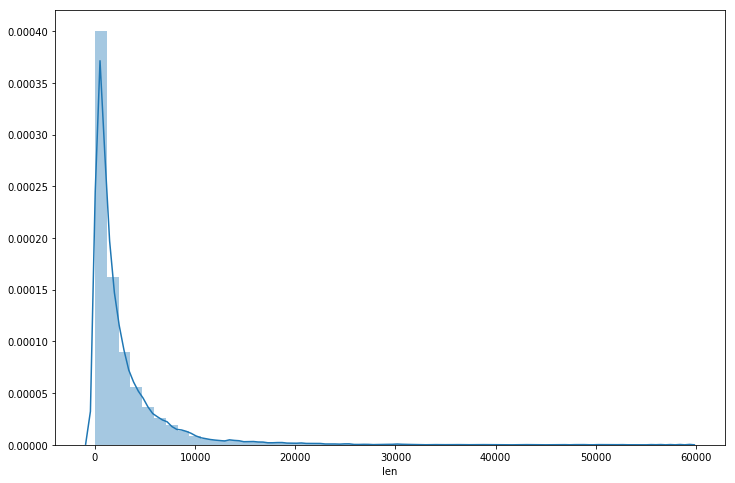

In [10]:
fig = plt.figure(figsize=(12,8))
sns.distplot(train_data2['len'])

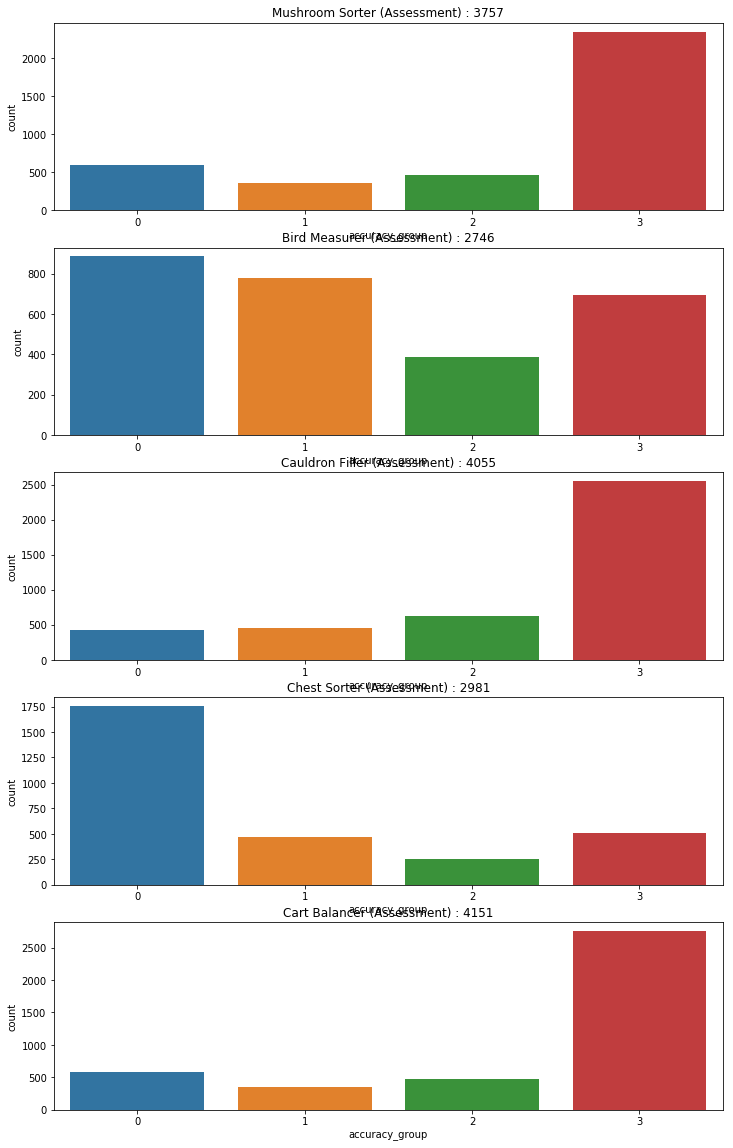

In [11]:
fig, ax = plt.subplots(5,1, figsize=(12,20))
for num, (title, df) in enumerate(train_data2.groupby('title', sort=False)):
    sns.countplot(df['accuracy_group'], ax=ax[num])
    ax[num].set_title("{} : {}".format(title, len(df)))

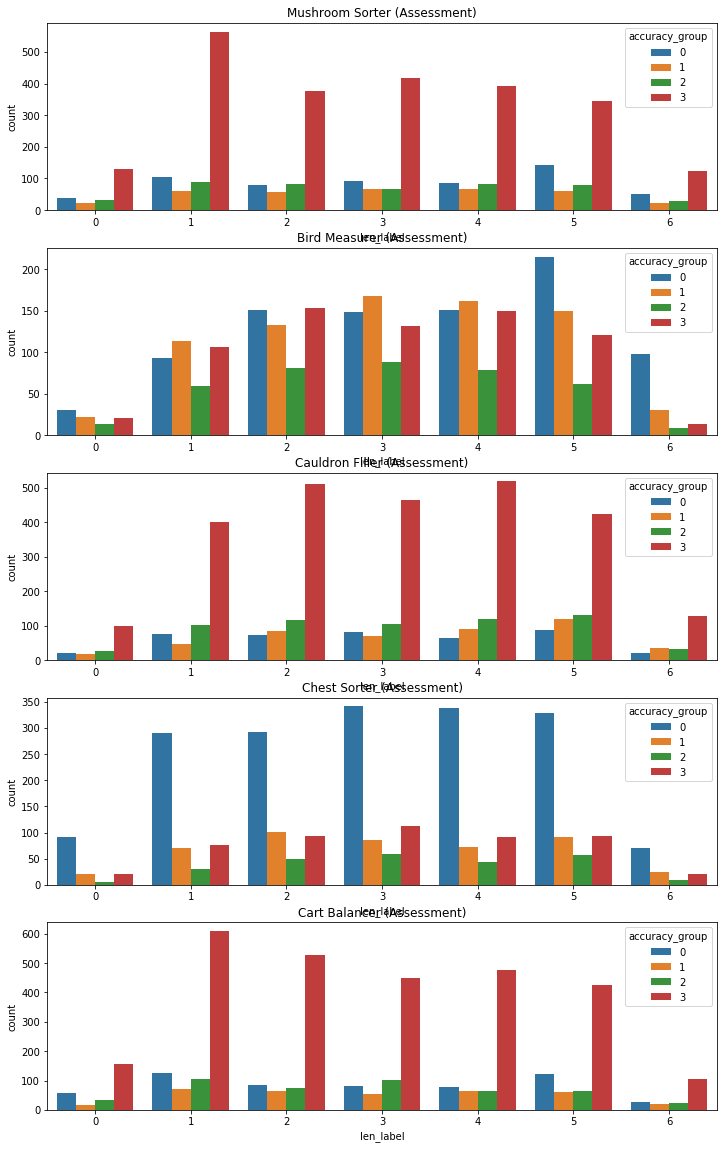

In [12]:
fig, ax = plt.subplots(5,1, figsize=(12,20))
for num, (title, df) in enumerate(train_data2.groupby('title', sort=False)):
    sns.countplot(df['len_label'], hue=df['accuracy_group'], ax=ax[num])
    ax[num].set_title(title)

* title과 len_group을 동일하게 나눠보자

* Bird 와 Chest는 따로 학습해보자.

In [13]:
idx_dict = dict()
title_gkf = GroupKFold(n_splits=5)

# 1. title을 나눈다
for num, (tr_idx, val_idx) in enumerate(title_gkf.split(train_data2, train_data2['accuracy_group'], groups=train_data['title'])):
    title_data = train_data2.loc[val_idx].reset_index()
    title = title_data['title'].unique()[0]
    idx_dict[title] = dict()
    
    # 2. title 별로 len_label를 나눈다.
    len_gkf = GroupKFold(n_splits=7)
    for num, (tr_idx, val_idx2) in zip(range(0, 7), len_gkf.split(title_data, title_data['accuracy_group'], groups=title_data['len_label'])):
        len_title_data = title_data.loc[val_idx2].sample(frac=1).reset_index()
        len_label = len_title_data['len_label'].unique()[0]
        idx_dict[title][len_label] = dict()
        
        # 3. 각 group을 5개씩 나눈다
        kf = KFold(n_splits=5)
        for i, (tr_idx2, val_idx3) in zip(range(0, 5), kf.split(len_title_data)):
            len_title_data_n = len_title_data.loc[val_idx3]
            idx_dict[title][len_label][i] = list(len_title_data_n['index'])
            random.shuffle(idx_dict[title][len_label][i])

In [14]:
idx_dict.keys()

dict_keys(['Cart Balancer (Assessment)', 'Cauldron Filler (Assessment)', 'Mushroom Sorter (Assessment)', 'Chest Sorter (Assessment)', 'Bird Measurer (Assessment)'])

In [15]:
title_list = list(train_data.title.unique())

In [16]:
val_dict = dict()
for z in range(0,5):
    val_dict[z] = dict()
    data = list()
    for j in range(0, 7):
        for i in title_list:
            data += list(idx_dict[i][j][z])
    val_dict[z] = data

[    4     9    28 ... 17677 17680 17688]
[    0     6     7 ... 17672 17674 17689]
[    1    12    14 ... 17684 17685 17686]
[    2     8    11 ... 17681 17683 17687]
[    3     5    13 ... 17665 17673 17682]


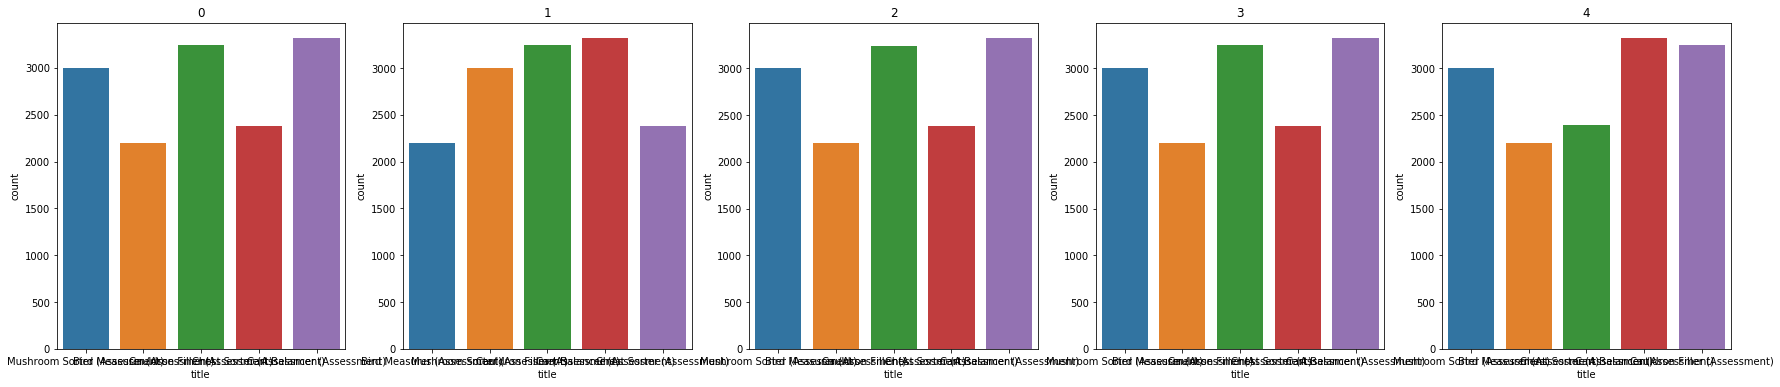

In [17]:
fig, ax = plt.subplots(1,5, figsize=(30,6))
for n_fold in range(5):
    val_idx = val_dict[n_fold]
    tr_idx = train_data.index[train_data.index.isin(val_idx) == False]
    print(np.sort(val_idx))
    sns.countplot(train_data2.loc[tr_idx]['title'], ax=ax[n_fold])
    #sns.countplot(train_data2.loc[tr_idx]['len_label'], ax=ax[n_fold])
    ax[n_fold].set_title(n_fold)

기존의 fold로 나누면?

In [18]:
kf = KFold(n_splits=5)

[   0    1    2 ... 3535 3536 3537]
[3538 3539 3540 ... 7073 7074 7075]
[ 7076  7077  7078 ... 10611 10612 10613]
[10614 10615 10616 ... 14149 14150 14151]
[14152 14153 14154 ... 17687 17688 17689]


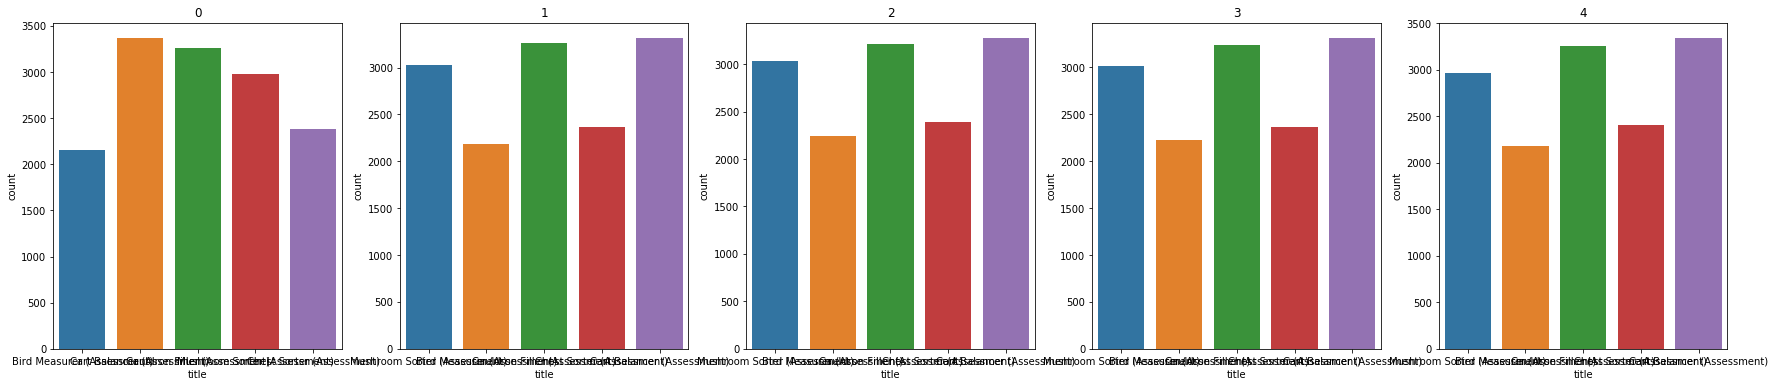

In [19]:
fig, ax = plt.subplots(1,5, figsize=(30,6))
for n_fold, (tr_idx, val_idx) in enumerate(kf.split(train_data2)):
    print(np.sort(val_idx))
    sns.countplot(train_data2.loc[tr_idx]['title'], ax=ax[n_fold])
    #sns.countplot(train_data2.loc[tr_idx]['accuracy_group'], ax=ax[n_fold])
    ax[n_fold].set_title(n_fold)

In [20]:
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [21]:
save_obj(val_dict, 'val_dict2')

title과 len_label 단계 변환

In [22]:
idx_dict = dict()
title_gkf = GroupKFold(n_splits=7)

# 1. len_label를 나눈다
for num, (tr_idx, val_idx) in enumerate(title_gkf.split(train_data2, train_data2['accuracy_group'], groups=train_data2['len_label'])):
    title_data = train_data2.loc[val_idx].reset_index()
    title = title_data['len_label'].unique()[0]
    idx_dict[title] = dict()
    
    # 2. title를 나눈다.
    len_gkf = GroupKFold(n_splits=5)
    for num, (tr_idx, val_idx2) in zip(range(0, 7), len_gkf.split(title_data, title_data['accuracy_group'], groups=title_data['title'])):
        len_title_data = title_data.loc[val_idx2].sample(frac=1).reset_index()
        len_label = len_title_data['title'].unique()[0]
        idx_dict[title][len_label] = dict()
        
        # 3. 각 group을 5개씩 나눈다.
        kf = KFold(n_splits=5)
        for i, (tr_idx2, val_idx3) in zip(range(0, 5), kf.split(len_title_data)):
            len_title_data_n = len_title_data.loc[val_idx3]
            idx_dict[title][len_label][i] = list(len_title_data_n['index'])
            random.shuffle(idx_dict[title][len_label][i])

In [23]:
val_dict = dict()
for z in range(0,5):
    val_dict[z] = dict()
    data = list()
    for i in title_list:
        for j in range(0, 7):
            data += list(idx_dict[j][i][z])
    val_dict[z] = data

[    4    14    15 ... 17657 17684 17689]
[    1     8    10 ... 17679 17681 17682]
[    2     5    18 ... 17663 17667 17683]
[    9    12    13 ... 17678 17680 17685]
[    0     3     6 ... 17686 17687 17688]


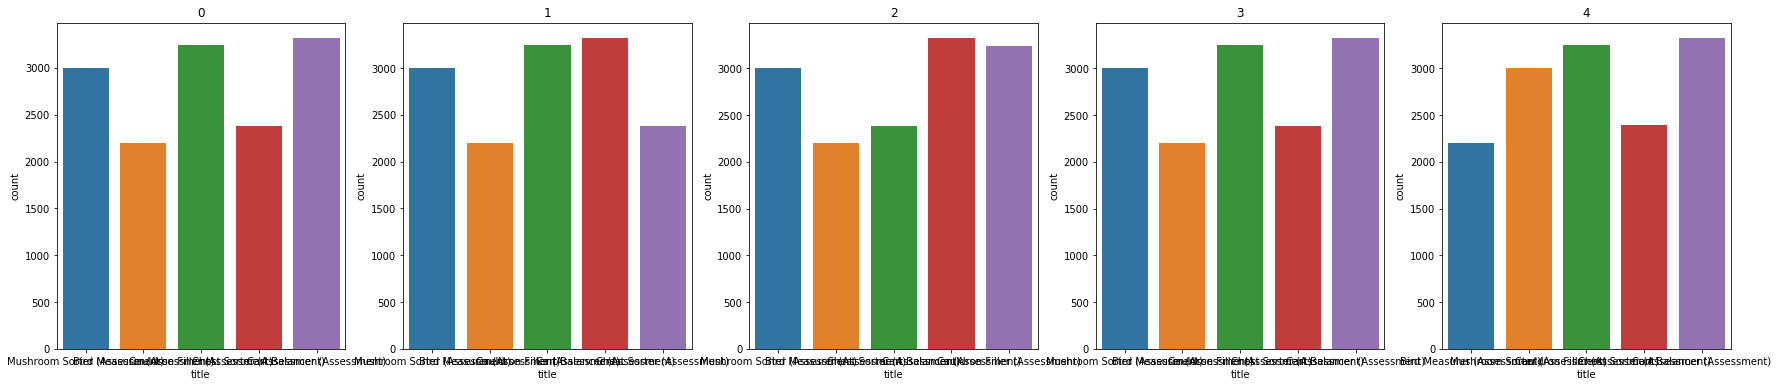

In [24]:
fig, ax = plt.subplots(1,5, figsize=(30,6))
for n_fold in range(5):
    val_idx = val_dict[n_fold]
    tr_idx = train_data.index[train_data.index.isin(val_idx) == False]
    print(np.sort(val_idx))
    sns.countplot(train_data2.loc[tr_idx]['title'], ax=ax[n_fold])
    #sns.countplot(train_data2.loc[tr_idx]['len_label'], ax=ax[n_fold])
    ax[n_fold].set_title(n_fold)

In [25]:
save_obj(val_dict, 'val_dict3')

모델에 사용

In [26]:
# train a baseline model and record the cohen cappa score as our best score
#for n_fold, (tr_idx, val_idx) in enumerate(kf.split(reduce_train)):
for n_fold in range(5):
    print("="*50)
    print('Training Start, fold : {}'.format(n_fold+1))
    print("="*50)
    val_idx = val_dict[n_fold]
    tr_idx = train_data.index[train_data.index.isin(val_idx) == False]

    #train_x, train_y = X[tr_idx], y[tr_idx]
    #valid_x, valid_y = X[val_idx], y[val_idx]

Training Start, fold : 1
Training Start, fold : 2
Training Start, fold : 3
Training Start, fold : 4
Training Start, fold : 5
